In [1]:
import itertools
from pomps.policy_scope import PolicyComponent, MixedPolicyScope
from pomis.scm import *
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.gp_fcm import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *

# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM

In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C", dist.Normal(U1, 0.1)), 'C'),
                             Functor(lambda C, U1: pyro.sample("X1", dist.Normal(U1+C, 0.1)), 'X1'),
                             Functor(lambda C, X1, U2: pyro.sample("X2", dist.Normal(C+X1, torch.abs(U2))), 'X2'),
                             Functor(lambda U2, X2, C: pyro.sample("X2", 
                                        dist.Normal(torch.cos(C-X2)+U2/100, 0.01)), "Y")}, sampler_over)

# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')
# ccg = MPSDAGController.simplify(ccg)

In [3]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", "X2"}, 
                      contextual_variables={"C", "X1"}, target='Y')
ccg = MPSDAGController.simplify(ccg)
space = [RealDomain("X1", -5, 5), RealDomain("X2", -5, 5), RealDomain("C", -5, 5)]
gpf = GPFunctorFactory(space)

In [4]:
ccg.interventional_variables, ccg.contextual_variables, ccg.uc_variables

({'X1', 'X2'}, {'C', 'X1'}, {'U1', 'U2'})

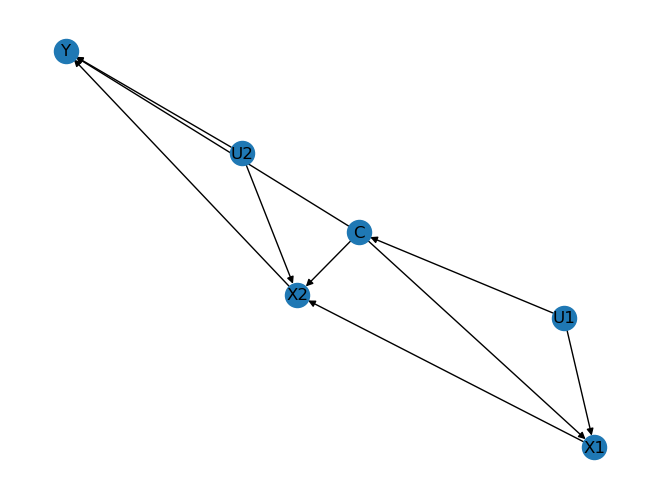

In [5]:
nx.draw(ccg, with_labels=True)

In [6]:
interventional_set = ccg.interventional_variables
contextual_set = ccg.contextual_variables

In [7]:
def all_combs(base, start=0):
    return list(itertools.chain(*[itertools.combinations(base, i) for i in range(start, len(base)+1)]))

def inter_cont_pair_gen(interventional_set, contextual_set):
    inter_segment = []
    context_space = all_combs(contextual_set)
    for inter in interventional_set:
        inter_segment += [[(inter, i) for i in context_space]]
    
    iam = all_combs(inter_segment)
    return itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], [])

def mpss(pair_gen):
    for mps_row in pair_gen:
        yield MixedPolicyScope({PolicyComponent(target, set(context))  for target, context in mps_row })

In [8]:
a = {1}
b = a
b = b | {2}

In [9]:
a, b

({1}, {1, 2})

In [10]:
mpses = list(mpss(inter_cont_pair_gen(interventional_set, contextual_set)))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
15
set()
call
set()
call
set()
call
{'C'}
call
set()
call
{'X1'} set()
{'X1', 'X2'} set()
{'X1', 'X2'} {'X1', 'X2'}
{'X1', 'X2'} {'X1', 'X2'}
{'C'}
call
{'X1', 'C'} {'C'}
{'X1', 'C', 'X2'} {'C'}
{'X1', 'C', 'X2'} {'X1', 'C', 'X2'}
{'X1', 'C', 'X2'} {'X1', 'C', 'X2'}
set()
call
set()
call
set()
call
{'C'}
call
{'X1', 'C'} {'C'}
{'X1', 'C', 'X2'} {'C'}
{'X1', 'C', 'X2'} {'X1', 'C', 'X2'}
{'X1', 'C', 'X2'} {'X1', 'C', 'X2'}
7
set()
call
{'X1'} set()
{'X1'} {'X1'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
{'X1'}
call
{'X1', 'X2'} {'X1'}
{'X1', 'X2'} {'X1', 'X2'}
{'C'}
call
{'C', 'X2'} {'C'}
{'C', 'X2'} {'C', 'X2'}
{'X1'}
call
{'X1', 'X2'} {'X1'}
{'X1', 'X2'} {'X1', 'X2'}
3


In [11]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x7fd3318bb310>, ),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fd3318c0b80>,
  <X1, {'C'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fd3318c0d00>,
  <X2, {'C'}>)]

In [13]:
graph, mps = graph_under_mps[-1]
mps

nx.draw(graph, with_labels=True)

policy = PolicyFCM.mps_to_gp_policy(mps, gpf)

fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

<X1, {'C'}>	<X2, {'X1'}>

In [17]:
for i in tqdm(range(80)):
    smp = fcm_m.sample()
    y = smp[graph.target]
    y = torch.tensor([y])
    for p in policy:
        p.functional.observe(-y)
    print(smp)

  0%|          | 0/80 [00:00<?, ?it/s]

{'C': tensor(-0.2400), 'X1': tensor(-5.), 'X2': tensor(-5.), 'Y': tensor(0.0435)}
{'C': tensor(0.4811), 'X1': tensor(0.), 'X2': tensor(0.), 'Y': tensor(0.8811)}
{'C': tensor(0.2933), 'X1': tensor(2.5000), 'X2': tensor(-2.5000), 'Y': tensor(-0.9377)}
{'C': tensor(-0.0559), 'X1': tensor(0.0081), 'X2': tensor(-0.0001), 'Y': tensor(0.9882)}
{'C': tensor(0.2434), 'X1': tensor(0.0287), 'X2': tensor(-0.0009), 'Y': tensor(0.9842)}
{'C': tensor(-0.3455), 'X1': tensor(0.1081), 'X2': tensor(-4.8294), 'Y': tensor(-0.2448)}
{'C': tensor(0.8322), 'X1': tensor(-4.4048), 'X2': tensor(4.8842), 'Y': tensor(-0.6051)}
{'C': tensor(-1.0689), 'X1': tensor(0.0201), 'X2': tensor(0.5061), 'Y': tensor(-0.0088)}
{'C': tensor(0.4274), 'X1': tensor(-0.0257), 'X2': tensor(-0.3369), 'Y': tensor(0.7171)}
{'C': tensor(-0.0599), 'X1': tensor(-0.0259), 'X2': tensor(-1.0214), 'Y': tensor(0.5856)}
{'C': tensor(0.7570), 'X1': tensor(-3.7899), 'X2': tensor(-0.0270), 'Y': tensor(0.7157)}
{'C': tensor(-0.5642), 'X1': tensor(-

In [20]:
fcm_m.functors['X2'].functional.optimizer.best_x, fcm_m.functors['X1'].functional.optimizer.best_x

(                X1        X2
 25  tensor(0.0387)  0.122044,
           X1               C
 25  0.038738  tensor(0.1065))

In [21]:
fcm_m.sample()

{'C': tensor(-0.1074),
 'X1': tensor(0.1549),
 'X2': tensor(-1.5137),
 'Y': tensor(0.1809)}

In [26]:
g = graph_under_mps[-2]
print(g[1])
MPSReductor.sufficiently_not_pomp(g[1], g[0])

<X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}


True

In [27]:
g[0].uc_variables

{'U1'}

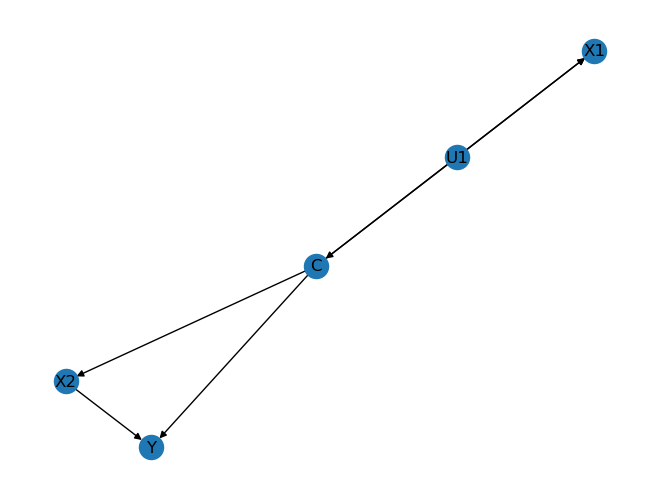

In [28]:
nx.draw(g[0], with_labels=True)

In [15]:
for idx, g in enumerate(graph_under_mps):
    print(idx, g[1])
    MPSReductor.sufficiently_not_pomp(g[1], g[0])

0 
1 <X2, set()>
set()
call
{'X2'} set()
{'X2'} {'X2'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
2 <X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
3 <X2, {'X1'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
4 <X1, set()>
set()
call
{'X1'} set()
{'X1'} {'X1'}
5 <X1, {'C'}>
6 <X2, {'X1'}>	<X1, {'C'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}


In [10]:
mps = MixedPolicyScope(dict())
MPSDAGController.graph_under_mps(mps, ccg), mps

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7f8e610e3130>, True), )

In [8]:
g = graph_under_mps[0]
MPSReductor.sufficiently_not_pomp(g[1], g[0][0])

False

In [9]:
g

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fed29561520>, True),
 <statin, set()>)

In [16]:
graph_under_mps[1]

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fcde0cb9580>, True),
 <aspirin, {'age'}>)

In [18]:
MPSReductor.action_relevance_check(graph_under_mps[0][1], graph_under_mps[0][0][0])

True

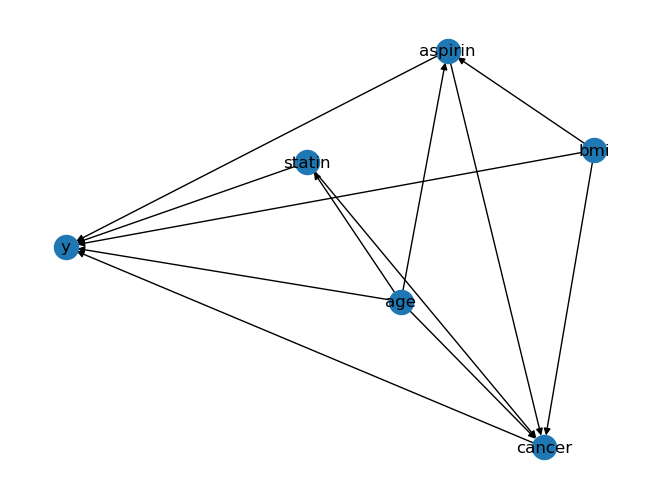

In [36]:
nx.draw(graph_under_mps[i][0], with_labels=True)

In [96]:
inter_segment = []
for inter in interventional_set:
    inter_segment += [[(inter, i) for i in contexts]]

In [104]:
iam = all_combs(inter_segment)
list(itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], []))

[(),
 (('X1', ()),),
 (('X1', ('C2',)),),
 (('X1', ('C1',)),),
 (('X1', ('C2', 'C1')),),
 (('X2', ()),),
 (('X2', ('C2',)),),
 (('X2', ('C1',)),),
 (('X2', ('C2', 'C1')),),
 (('X1', ()), ('X2', ())),
 (('X1', ()), ('X2', ('C2',))),
 (('X1', ()), ('X2', ('C1',))),
 (('X1', ()), ('X2', ('C2', 'C1'))),
 (('X1', ('C2',)), ('X2', ())),
 (('X1', ('C2',)), ('X2', ('C2',))),
 (('X1', ('C2',)), ('X2', ('C1',))),
 (('X1', ('C2',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C1',)), ('X2', ())),
 (('X1', ('C1',)), ('X2', ('C2',))),
 (('X1', ('C1',)), ('X2', ('C1',))),
 (('X1', ('C1',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C2', 'C1')), ('X2', ())),
 (('X1', ('C2', 'C1')), ('X2', ('C2',))),
 (('X1', ('C2', 'C1')), ('X2', ('C1',))),
 (('X1', ('C2', 'C1')), ('X2', ('C2', 'C1')))]

In [100]:
list(itertools.product(interventional_set, contexts))

[('X1', ()),
 ('X1', ('C2',)),
 ('X1', ('C1',)),
 ('X1', ('C2', 'C1')),
 ('X2', ()),
 ('X2', ('C2',)),
 ('X2', ('C1',)),
 ('X2', ('C2', 'C1'))]